# Adaptive PDE discretizations on cartesian grids 
## Volume : Reproducible research
## Part : Eikonal CPU/GPU solvers comparison
## Chapter : Asymmetric-Quadratic metrics

In this notebook, we solve Asymmetric-Quadratic eikonal equations on the CPU and the GPU, and check that they produce consistent results.

*Note on the numerical schemes*: The numerical schemes solved by the CPU and the GPU in the Asymmetric-Quadratic case are entirely different. The CPU version uses a causal semi-Lagrangian scheme, in two dimensions, and a causal Eulerian scheme in three dimensions, which is only approximately consistent. The GPU version uses a non-causal (yet monotone) Eulerian scheme, in any dimension.

[**Summary**](Summary.ipynb) of volume Reproducible research, this series of notebooks.

[**Main summary**](../Summary.ipynb) of the Adaptive Grid Discretizations 
	book of notebooks, including the other volumes.

# Table of contents
  * [1. Two dimensions](#1.-Two-dimensions)
  * [2. Three dimensions](#2.-Three-dimensions)



**Acknowledgement.** The experiments presented in these notebooks are part of ongoing research, 
some of it with PhD student Guillaume Bonnet, in co-direction with Frederic Bonnans.

Copyright Jean-Marie Mirebeau, University Paris-Sud, CNRS, University Paris-Saclay


## 0. Importing the required libraries

In [2]:
import sys; sys.path.insert(0,"..")
#from Miscellaneous import TocTools; print(TocTools.displayTOC('AsymQuad_GPU','Repro'))

In [6]:
from agd import AutomaticDifferentiation as ad
if ad.cupy_generic.cp is None: raise ad.DeliberateNotebookError('Cupy module required')
from agd import Eikonal
from agd import Metrics
from agd import FiniteDifferences as fd
from agd import LinearParallel as lp
import agd.AutomaticDifferentiation.cupy_generic as cugen

DeliberateNotebookError: Cupy module required

In [3]:
import cupy as cp
import numpy as np
import itertools
from matplotlib import pyplot as plt
np.set_printoptions(edgeitems=30, linewidth=100000, formatter=dict(float=lambda x: "%5.3g" % x))

DeliberateNotebookError: cupy module required

In [4]:
from agd.ExportedCode.Notebooks_Repro.Isotropic_GPU import RunCompare

ModuleNotFoundError: No module named 'agd.ExportedCode.Notebooks_Repro.Isotropic_GPU'

In [5]:
cp = ad.functional.decorate_module_functions(cp,cugen.set_output_dtype32)
plt = ad.functional.decorate_module_functions(plt,cugen.cupy_get_args)
Eikonal.dictIn.default_mode = 'gpu'

In [6]:
def ReloadPackages():
    from Miscellaneous.rreload import rreload
    global HFMUtils,ad,cugen,RunSmart,Metrics
    Eikonal,ad,cugen,Metrics = rreload([Eikonal,ad,cugen,Metrics],"../..")    
    Eikonal.dictIn.default_mode = 'gpu'

### 0.1 Additional configuration

In [ ]:
large_instances = False # True favors the GPU code (CPU times may become a big long.)
strong_anisotropy = True # True favors the CPU code 

## 1. Two dimensions

In [7]:
n=2000 if large_instances else 200
asym = 4. if strong_anisotropy else 1.
hfmIn = Eikonal.dictIn({
    'model':'AsymmetricQuadratic2',
    'seed':[0.,0.],
    'exportValues':1,
    'factoringRadius':20,
    'count_updates':True,
#    'bound_active_blocks':True,
#    'traits':{'niter_i':16}
})
hfmIn.SetRect([[-1,1],[-1,1]],dimx=n+1,sampleBoundary=True)
hfmIn.SetUniformTips((6,6))
hfmIn['metric'] = Metrics.AsymQuad(cp.eye(2),cp.array([asym,0.]) ).rotate_by(cp.array(0.5))
X = hfmIn.Grid()

In [8]:
#gpuOut = hfmIn.Run()

 The CPU and gpu code produce identical similar results, despite the very distinct implementations.

In [10]:
gpuOut,cpuOut = RunCompare(hfmIn,check=0.015)

Setting the kernel traits.
Prepating the domain data (shape,metric,...)
Preparing the problem rhs (cost, seeds,...)
Preparing the GPU kernel
Running the eikonal GPU kernel
GPU kernel eikonal ran for 0.06301760673522949 seconds, and 79 iterations.
Post-Processing
--- gpu done, turning to cpu ---
Field verbosity defaults to 1
Field cosAngleMin defaults to 0.5
Field refineStencilAtWallBoundary defaults to 0
Field order defaults to 1
Field seedRadius defaults to 2
Fast marching solver completed in 0.083 s.
Field geodesicSolver defaults to Discrete
Field geodesicStep defaults to 0.25
Field geodesicWeightThreshold defaults to 0.001
Field geodesicVolumeBound defaults to 8.45
***** Warning ! *****
Unused fields from user: count_updates 
********************
Solver time (s). GPU : 0.06301760673522949, CPU : 0.167. Device acceleration : 2.6500530352042073
Max |gpuValues-cpuValues| :  0.011851862290224613


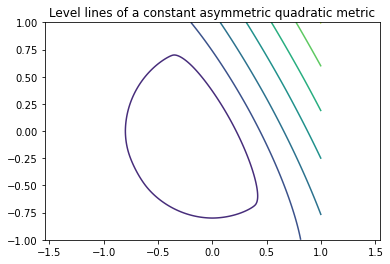

In [11]:
plt.title('Level lines of a constant asymmetric quadratic metric'); plt.axis('equal')
plt.contour(*X,gpuOut['values']);

The geodesics are straight lines, as expected for a constant metric.

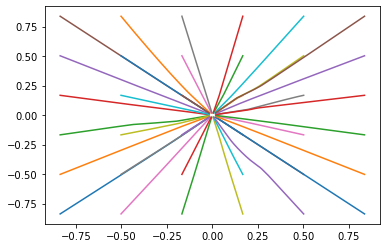

In [12]:
for geo in gpuOut['geodesics']: plt.plot(*geo)

The GPU acceleration depends on the strength of the anisotropy, on the instance size, and on the dimension.

Unfortunately, it is often modest. This is due to the very large number of updates applied to each block, often in excess of 300. This is presumably due to the non-causality of the scheme. Future work will be devoted to improving this situation.

In [13]:
nupdate = gpuOut['stats']['eikonal']['nupdate_o'].get()
np.mean(nupdate),np.max(nupdate)

(23.983727810650887, 54)

The number of updates is increasing almost linearly in all directions, from the seed point. This is a strong hint that a mechanism for bounding the front width is needed.

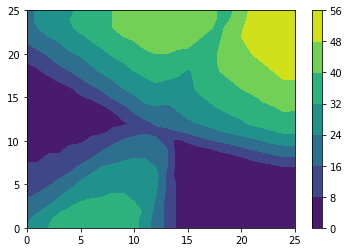

In [14]:
plt.contourf(gpuOut['stats']['eikonal']['nupdate_o']); plt.colorbar()

## 2. Three dimensions

In [37]:
n=200 if large_instances else 50
asym = 4. if strong_anisotropy else 1.
hfmIn = Eikonal.dictIn({
    'model':'AsymmetricQuadratic3',
    'seed':[0.,0.,0.],
    'exportValues':1,
#    'factoringRadius':20, # 3D cpu version does not support factoring
    'count_updates':True,
#    'bound_active_blocks':True,
#    'traits':{'niter_i':16}
})
hfmIn.SetRect([[-1,1],[-1,1],[-1,1]],dimx=n+1,sampleBoundary=True)
hfmIn.SetUniformTips((6,6,6))
hfmIn['metric'] = Metrics.AsymQuad(cp.eye(3),cp.array([asym,0.,0.]) ).rotate_by(cp.array(0.5),cp.array([1.,2.,3.]) )
X = hfmIn.Grid()

In [39]:
#gpuOut = hfmIn.Run()

In [18]:
gpuOut,cpuOut = RunCompare(hfmIn,check=0.15)

Setting the kernel traits.
Prepating the domain data (shape,metric,...)
Preparing the problem rhs (cost, seeds,...)
Preparing the GPU kernel
Running the eikonal GPU kernel
GPU kernel eikonal ran for 0.1229851245880127 seconds, and 59 iterations.
Post-Processing
--- gpu done, turning to cpu ---
Field verbosity defaults to 1
Field eps defaults to 0.3
Field order defaults to 1
Field seedRadius defaults to 0
Fast marching solver completed in 0.712 s.
Field geodesicSolver defaults to Discrete
Field geodesicStep defaults to 0.25
Field geodesicWeightThreshold defaults to 0.001
Field geodesicVolumeBound defaults to 10.985
***** Warning ! *****
Unused fields from user: count_updates 
********************
Solver time (s). GPU : 0.1229851245880127, CPU : 1.321. Device acceleration : 10.741136413246819
Max |gpuValues-cpuValues| :  0.10102932782074481


Again, the number of GPU updates is higher than we would like it to be. The situation is not a bad as in two dimensions, nevertheless, because the domain is less wide.

In [19]:
nupdate = gpuOut['stats']['eikonal']['nupdate_o'].get()
np.mean(nupdate),np.max(nupdate)

(21.495220755575787, 43)

The GPU solver can handle source factorization, which substantially reduces error.

In [40]:
hfmIn['factoringRadius']=20
gpuOut2 = hfmIn.Run()

Setting the kernel traits.
Prepating the domain data (shape,metric,...)
Preparing the problem rhs (cost, seeds,...)
Preparing the GPU kernel
Running the eikonal GPU kernel
GPU kernel eikonal ran for 0.10997581481933594 seconds, and 62 iterations.
Post-Processing


In [42]:
exact = hfmIn['metric'].norm(X)
print('Error without factorization : ',np.mean(np.abs(gpuOut['values']-exact)) )
print('Error with factorization : ',np.mean(np.abs(gpuOut2['values']-exact)) )

Error without factorization :  0.09841735
Error with factorization :  0.006476
